### 在20171017_05xgboost_under_sampling调优得到参数基础上，利用EasyEnsemble方法训练多个模型进行集成

In [2]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

In [3]:
train_df=pd.read_csv('/home/yw/study/Competition/Safe_Driver_Prediction_20171014/train.csv',na_values=-1)
test_df=pd.read_csv('/home/yw/study/Competition/Safe_Driver_Prediction_20171014/test.csv',na_values=-1)
sample_df=pd.read_csv('/home/yw/study/Competition/Safe_Driver_Prediction_20171014/sample_submission.csv')

In [4]:
train_df.fillna(np.nan,inplace=True)
test_df.fillna(np.nan,inplace=True)

In [5]:
train_df.head(3)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0


In [6]:
#所有二元变量
bin_features=[feat for feat in train_df.columns if 'bin' in feat]
#所有的分类变量
cat_features=[feat for feat in train_df.columns if 'cat' in feat]

### best params

In [10]:
bst_params={'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1.0,
 'gamma': 0.067,
 'learning_rate': 0.071,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 0.90000000000000002,
 'missing': None,
 'n_estimators': 237,
 'nthread': -1,
 'objective': 'binary:logistic',
 'reg_alpha': 14,
 'reg_lambda': 0.841,
 'scale_pos_weight': 1.0,
 'seed': 9,
 'silent': True,
 'subsample': 1.0}

# 1 Data split

In [7]:
use_features=[x for x in train_df.columns if x not in ['id','target']]

In [8]:
X=train_df[use_features]
y=train_df['target']

X_predict=test_df[use_features]

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,stratify=y,random_state=9)

# 2 model

### 创建集成学习类

In [77]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() 

def gini_normalized(preds,dtrain):
    y=dtrain.get_label()
    preds=softmax(preds)
    return 'NormGini',-gini(y, preds) / gini(y, y)

def gini_normalized_ordinary(y,preds):
    return gini(y, preds) / gini(y, y)

def gini_normalized_ordinary_1(preds,y):
    return gini(y, preds) / gini(y, y)

def gini_normalized_ordinary_model(model,X,y):
    preds=model.predict_proba(X)[:,1]
    return gini(y, preds) / gini(y, y)


def modelfit(alg,X,y,X_test,y_test,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    if useTrainCV==True:
        xgb_param=alg.get_xgb_params()
        xgtrain=xgb.DMatrix(X,label=y,missing=None)
        cvresult=xgb.cv(xgb_param,xgtrain,num_boost_round=50000,nfold=cv_folds,feval=gini_normalized,
                        early_stopping_rounds=early_stopping_rounds,verbose_eval=20)
        alg.set_params(n_estimators=cvresult.shape[0])
        print('Best Iteration:',cvresult.shape[0])
        
    alg.fit(X,y,eval_metric=gini_normalized)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    dtrain_predprob=alg.predict_proba(X)[:,1]
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    dtest_predprob=alg.predict_proba(X_test)[:,1]
    
    #Print Mode report:
    print('Model report on trian:')
    print('Train Accuracy:{0:.4f}'.format(metrics.accuracy_score(y,dtrain_predictions)))
    print('Train AUC:{0:.4f}'.format(metrics.roc_auc_score(y,dtrain_predprob)))
    print('Train Normalized GINI：{0:.6f}'.format(gini_normalized_ordinary(y,dtrain_predprob)))
    print('Model report on test:')
    print('Test Accuracy:{0:.4f}'.format(metrics.accuracy_score(y_test,dtest_predictions)))
    print('Test AUC:{0:.4f}'.format(metrics.roc_auc_score(y_test,dtest_predprob)))
    print('Test Normalized GINI：{0:.6f}'.format(gini_normalized_ordinary(y_test,dtest_predprob)))
    print('Test classifiction report:')
    print(metrics.classification_report(y_test,dtest_predictions))
    print('Test confusion matrix:')
    plt.figure()
    with sns.axes_style(style='dark'):
        plot_confusion_matrix(metrics.confusion_matrix(y_test,dtest_predictions),classes=['0','1'],
                             title='Confusion Matrix')
    plt.figure()
    feat_imp=pd.Series(alg.booster().get_fscore()).sort_values(ascending=True)
    feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    plt.ylabel('Feature Importance Score')
    return feat_imp

def turnParams(model,X,y,searchParam,modelparams,scoring='roc_auc',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y)
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score']).T
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [43]:
class EasyEnsembleXGB:
    
    def __init__(self,params,n_estimators=10):
        self.params=params
        self.n_estimators=n_estimators
        self.__models=None
    #under sampling  data   
    def under_sampling(self,X,y,random_state=None):
        X_P=X.loc[y==1]
        X_N=X.loc[y==0]

        y_P=y[y==1]
        y_N=y[y==0]
    
        X_N_sample,y_N_sample=shuffle(X_N,y_N,random_state=random_state,n_samples=X_P.shape[0])
        X_sample,y_sample=shuffle(X_N_sample.append(X_P),y_N_sample.append(y_P))
    
        return X_sample,y_sample
    
    def fit(self,X,y,verbose=0):
        self.__models=[]
        msg_show_flag=verbose
        for i in range(self.n_estimators):
            X_sample,y_sample=under_sampling(X,y)
            xgbm=XGBClassifier(**self.params)

            if verbose>0:
                if msg_show_flag==verbose:
                    msg_show_flag=0
                    print('model_{0} is fitting...'.format(i+1))
            msg_show_flag+=1
            xgbm.fit(X_sample,y_sample)
            self.__models.append(xgbm)
        return self
    
    def predict_proba(self,X):
        if self.__models is None:
            print('This model not fitted!')
            return None
        if len(self.__models)==0:
            print('This model not fitted!')
            return None
        self.preds=[]
        for model in self.__models:
            self.preds.append(model.predict_proba(X)[:,1])
        return self.preds

In [44]:
xgb_ensemble=EasyEnsembleXGB(bst_params,n_estimators=500)

In [45]:
xgb_ensemble.fit(X_train,y_train,verbose=10)

model_1 is fitting...
model_11 is fitting...
model_21 is fitting...
model_31 is fitting...
model_41 is fitting...
model_51 is fitting...
model_61 is fitting...
model_71 is fitting...
model_81 is fitting...
model_91 is fitting...
model_101 is fitting...
model_111 is fitting...
model_121 is fitting...
model_131 is fitting...
model_141 is fitting...
model_151 is fitting...
model_161 is fitting...
model_171 is fitting...
model_181 is fitting...
model_191 is fitting...
model_201 is fitting...
model_211 is fitting...
model_221 is fitting...
model_231 is fitting...
model_241 is fitting...
model_251 is fitting...
model_261 is fitting...
model_271 is fitting...
model_281 is fitting...
model_291 is fitting...
model_301 is fitting...
model_311 is fitting...
model_321 is fitting...
model_331 is fitting...
model_341 is fitting...
model_351 is fitting...
model_361 is fitting...
model_371 is fitting...
model_381 is fitting...
model_391 is fitting...
model_401 is fitting...
model_411 is fitting...
mod

### 2.2 find the best n_estimators

In [48]:
test_pred_probs=xgb_ensemble.predict_proba(X_test)

In [52]:
test_pred_probs=np.array(test_pred_probs)

In [71]:
test_pred_probs_cum=test_pred_probs.cumsum(axis=0)

In [69]:
sample_cnt=np.ones(test_pred_probs.shape[0])
sample_cnt=sample_cnt.cumsum()

In [82]:
test_pred_probs_cummean=test_pred_probs_cum/sample_cnt.reshape(-1,1)

In [83]:
gini_values=[]
for i in range(test_pred_probs_cummean.shape[0]):
    gini_values.append(gini_normalized_ordinary(y_test,test_pred_probs_cummean[i,:]))

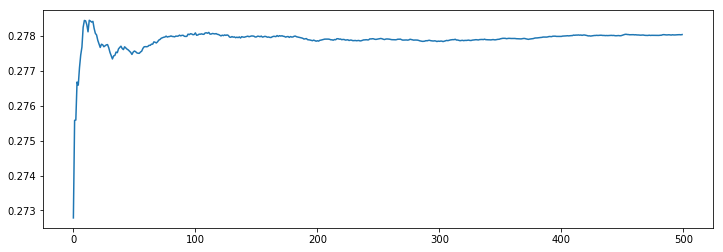

In [85]:
plt.plot(np.arange(len(gini_values)),gini_values)

In [86]:
gini_values=np.array(gini_values)

In [88]:
gini_values.argmax(),gini_values.max()

(13, 0.27845474650127838)

## 3 Predict

In [89]:
xgb_ensemble_opt=EasyEnsembleXGB(bst_params,n_estimators=13)

In [91]:
xgb_ensemble_opt.fit(X,y,verbose=2)

model_1 is fitting...
model_3 is fitting...
model_5 is fitting...
model_7 is fitting...
model_9 is fitting...
model_11 is fitting...
model_13 is fitting...


In [92]:
pred_probs=xgb_ensemble_opt.predict_proba(X_predict)

In [94]:
pred_prob=np.array(pred_probs).mean(axis=0)

In [95]:
predict_result=pd.DataFrame({'id':test_df['id'].astype(int),'target':pd.Series(pred_prob,index=test_df['id'].index)})

In [96]:
predict_result.head()

,id,target
0,0,0.408732
1,1,0.454415
2,2,0.437680
3,3,0.290158
4,4,0.504569


In [97]:
predict_result.to_csv('/home/yw/study/Competition/Safe_Driver_Prediction_20171014/20171017_06xgb_easyensemble.csv',index=False)